In [1]:
import pandas as pd

df = pd.read_csv('data/train.tsv/train.tsv',sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64

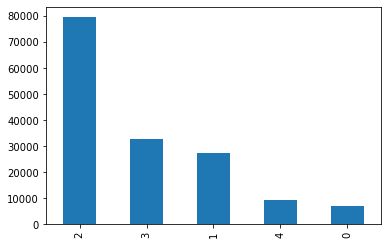

In [2]:
df['Sentiment'].value_counts().plot(kind='bar')
df['Sentiment'].value_counts(normalize=True)

数据增强

In [3]:
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from numpy import random


def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lm in syn.lemmas():
            synonyms.append(lm.name())
    return set(synonyms)

def synonym_replacement(words, n=5):
    stop_words = stopwords.words('english')
    new_words = words
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            #print("replaced", random_word, "with", synonym)
            num_replaced += 1
        if num_replaced >= n: #only replace up to n words
            break

    #this is stupid but we need it, trust me
    sentence = ' '.join(new_words)

    return sentence

In [4]:
from tqdm import tqdm

def synonym_dataaug(df,weight):
    sentiment_aug = df['Sentiment'].values.tolist()
    phrase_aug = df['Phrase'].values.tolist()

    df_len = len(sentiment_aug)
    for i in tqdm(range(df_len)):
        sentiment_aug.extend([sentiment_aug[i] for j in range(weight[sentiment_aug[i]])])
        phrase_aug.extend([synonym_replacement(phrase_aug[i].split(' ')) for j in range(weight[sentiment_aug[i]])])
    
    return pd.DataFrame({"Phrase":phrase_aug,"Sentiment":sentiment_aug})
    

In [5]:
df_aug = synonym_dataaug(df,[9,2,0,1,7])

100%|██████████| 156060/156060 [01:04<00:00, 2433.93it/s]


1    0.220167
2    0.214147
4    0.198179
0    0.190300
3    0.177206
Name: Sentiment, dtype: float64
df aug shape :  (371623, 2)


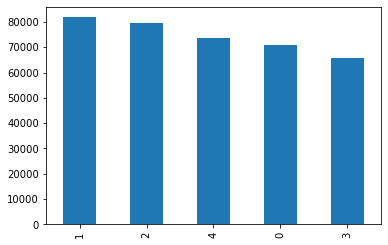

In [6]:
df_aug['Sentiment'].value_counts().plot(kind='bar')
print(df_aug['Sentiment'].value_counts(normalize=True))
print('df aug shape : ',df_aug.shape)

In [7]:
df['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [8]:
import string 

'''
    单词预处理，将单词全部小写，并且去除标点符号
'''
def preprocessing(phrase):
    lower = [phras.lower() for phras in phrase]    # 将字母全部小写
    no_punct = [text.translate(str.maketrans('','',string.punctuation)) for text in lower]   # 去掉标点符号
    sp = [text.split() for text in no_punct]
    res = [' '.join(lis) for lis in sp]

    return res

df['Phrase'] = preprocessing(df['Phrase'])
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2


In [9]:
df['Phrase'][0]

'a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story'

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,TensorDataset
import numpy as np


# 定义数据读取类
class MyDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self,df,vocab_path='data/glove.6B/glove.6B.300d.txt',word_len=300):
        """
        步骤二：实现构造函数，定义数据读取方式，划分训练和测试数据集
        """
        super(MyDataset, self).__init__()
        
        self.vocab_path = vocab_path
        self.wordlen = word_len
        _, _, self.word_to_vec_map = self.load_glove_embeddings()


        self.data =np.nan_to_num(np.array([self.sentence_to_avg(text) for text in df['Phrase']]),nan=0)


        self.label = [la for la in df['Sentiment']]


    def __getitem__(self, index):
        """
        步骤三:实现__getitem__方法,定义指定index时如何获取数据,并返回单条数据(训练数据，对应的标签)
        """
        d = torch.tensor(self.data[index],dtype=torch.float32)   
        l = torch.tensor(self.label[index],dtype=torch.long)

        return d,l

    def __len__(self):
        """
        步骤四:实现__len__方法:返回数据集总数目
        """
        return self.data.shape[0]
    

    # 将句子转换为向量
    def sentence_to_avg(self,sentence):
        words = sentence.lower().strip().split()
        
        avg = np.zeros(self.wordlen,)
        
        for w in words:
            if w in self.word_to_vec_map.keys():  # 如果不在词表里面，则该向量设置为全零
                avg += self.word_to_vec_map[w]
        
        avg = avg / len(words)
        
        return avg

    # 加载GloVe词嵌入
    def load_glove_embeddings(self):
        with open(self.vocab_path, 'r', encoding='utf-8') as f:
            words = set()
            word_to_vec_map = {}
            
            for line in f:
                line = line.strip().split()
                curr_word = line[0]
                words.add(curr_word)
                word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float32)
            
            i = 1
            words_to_index = {}
            index_to_words = {}
            for w in sorted(words):
                words_to_index[w] = i
                index_to_words[i] = w
                i = i + 1
        return words_to_index, index_to_words, word_to_vec_map

In [11]:
from sklearn.model_selection import train_test_split

train_df,dev_df = train_test_split(df,test_size=0.1,random_state=42)

# 训练数据 进行数据增强
train_df = synonym_dataaug(train_df,[3,1,0,1,3])

100%|██████████| 140454/140454 [00:53<00:00, 2639.41it/s]


In [12]:
train_dataset = MyDataset(train_df)
train_loader = DataLoader(train_dataset,32,shuffle=True)

dev_dataset = MyDataset(dev_df)
dev_loader = DataLoader(dev_dataset,32,shuffle=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11184\137047108.py:55: RuntimeWarning: invalid value encountered in true_divide
  avg = avg / len(words)


In [13]:
cnt = 0
for trains, labels in train_dataset:
    if cnt == 0:

        print(trains)
        print(labels)
    cnt += 1

tensor([ 2.1276e-03, -2.2197e-01,  6.4326e-02, -2.7800e-01, -6.1729e-02,
        -1.9566e-01, -1.9008e-01, -4.1553e-02, -1.0493e-01, -5.0115e-01,
         1.4418e-01, -6.9267e-02, -2.1731e-01,  1.1661e-02, -2.0700e-04,
         9.1448e-02, -1.3151e-01,  1.0881e-02,  1.4332e-01,  4.0839e-02,
         5.5388e-02, -1.0229e-01,  1.5621e-01, -1.4271e-02,  1.6602e-02,
         8.3729e-02,  1.1173e-01, -2.0185e-01, -1.3646e-02, -1.8593e-01,
         1.4688e-01,  1.5315e-01,  1.9309e-01,  1.2108e-01, -4.7660e-01,
        -1.2649e-01,  2.2400e-01,  1.9865e-01,  3.9129e-02,  2.7049e-02,
         6.7611e-02,  1.2576e-02, -1.3100e-01,  1.5875e-01, -5.0877e-02,
        -1.3839e-01, -6.2898e-02,  5.5798e-02, -4.2659e-02, -1.5957e-01,
        -2.6173e-03, -1.2671e-01, -7.8191e-02, -6.9357e-02,  9.5163e-02,
         1.0222e-01,  7.8807e-02,  1.7340e-01,  2.4614e-02, -9.5348e-02,
        -2.8437e-02, -7.5854e-02,  9.2298e-02,  1.0740e-01, -1.6900e-02,
        -2.2181e-01, -7.6209e-02, -2.9010e-01,  3.6

训练NN模型

In [14]:
from importlib import import_module

model_name = 'NN'

x = import_module('models.' + model_name)
config = x.Config()
print('all class number : ',config.num_classes)

all class number :  5


In [15]:
from train import train

model = x.Model(config).to(config.device)

train(config,model,train_loader,dev_loader,dev_loader)

Epoch [1/50]


100%|██████████| 10428/10428 [00:59<00:00, 176.07it/s]


train loss : 1.0982 ,train acc:0.539 , dev loss : 1.0755,dev acc : 0.546 
saving model ...
Epoch [2/50]


100%|██████████| 10428/10428 [00:56<00:00, 183.14it/s]


train loss : 1.0192 ,train acc:0.573 , dev loss : 1.0023,dev acc : 0.577 
saving model ...
Epoch [3/50]


100%|██████████| 10428/10428 [00:56<00:00, 183.21it/s]


train loss : 0.9448 ,train acc:0.606 , dev loss : 0.9992,dev acc : 0.585 
saving model ...
Epoch [4/50]


100%|██████████| 10428/10428 [00:56<00:00, 183.34it/s]


train loss : 0.8876 ,train acc:0.629 , dev loss : 0.9807,dev acc : 0.589 
saving model ...
Epoch [5/50]


100%|██████████| 10428/10428 [00:56<00:00, 184.36it/s]


train loss : 0.8571 ,train acc:0.645 , dev loss : 0.9983,dev acc : 0.588 
Epoch [6/50]


100%|██████████| 10428/10428 [00:57<00:00, 181.98it/s]


train loss : 0.8049 ,train acc:0.665 , dev loss : 1.0295,dev acc : 0.584 
Epoch [7/50]


100%|██████████| 10428/10428 [00:57<00:00, 181.90it/s]


train loss : 0.7678 ,train acc:0.686 , dev loss : 0.9698,dev acc : 0.605 
saving model ...
Epoch [8/50]


100%|██████████| 10428/10428 [00:57<00:00, 182.21it/s]


train loss : 0.7320 ,train acc:0.700 , dev loss : 0.9975,dev acc : 0.593 
Epoch [9/50]


100%|██████████| 10428/10428 [00:56<00:00, 186.16it/s]


train loss : 0.7086 ,train acc:0.711 , dev loss : 1.0036,dev acc : 0.593 
Epoch [10/50]


100%|██████████| 10428/10428 [00:56<00:00, 183.74it/s]


train loss : 0.6783 ,train acc:0.726 , dev loss : 1.0039,dev acc : 0.603 
Epoch [11/50]


100%|██████████| 10428/10428 [00:56<00:00, 183.67it/s]


train loss : 0.6514 ,train acc:0.737 , dev loss : 1.0307,dev acc : 0.599 
Epoch [12/50]


100%|██████████| 10428/10428 [00:56<00:00, 183.61it/s]


train loss : 0.6208 ,train acc:0.750 , dev loss : 1.0339,dev acc : 0.606 
Epoch [13/50]


100%|██████████| 10428/10428 [00:56<00:00, 185.11it/s]


train loss : 0.6084 ,train acc:0.757 , dev loss : 1.0526,dev acc : 0.594 
Epoch [14/50]


 10%|▉         | 1024/10428 [00:05<00:52, 180.75it/s]


KeyboardInterrupt: 

使用NN模型预测结果

In [16]:
df = pd.read_csv('data/test.tsv/test.tsv',sep='\t')
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [17]:
from tqdm import tqdm

'''
    使用model模型预测test_loader标签
'''
def predict_test_data(config,model,test_loader):
    pred = []
    for X,y in tqdm(test_loader):

        data = X.to(config.device)
        out = model(data)
        lab = out.argmax(dim=1) #argmax():返回最大数的索引


        pred.extend(lab.detach().cpu().numpy().tolist())
    return pred

In [18]:
df = pd.read_csv('data/test.tsv/test.tsv',sep='\t')
df['Phrase'] = preprocessing(df['Phrase'])

df['Sentiment'] = [2] * df.shape[0]

In [19]:
test_dataset = MyDataset(df)
test_loader = DataLoader(test_dataset,32,shuffle=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11184\137047108.py:55: RuntimeWarning: invalid value encountered in true_divide
  avg = avg / len(words)


In [20]:
model_name = 'output/NN_2023-02-17_17-09-49'
print('load_model name : ',model_name)
net = x.Model(config).to(config.device)
net.load_state_dict(torch.load(model_name))

test_pred = predict_test_data(config,net,test_loader)

load_model name :  output/NN_2023-02-17_17-09-49


100%|██████████| 2072/2072 [00:02<00:00, 891.64it/s] 


In [21]:
Submission_path = 'data/sampleSubmission.csv'
submission = pd.read_csv(Submission_path)
submission.Sentiment = test_pred

In [22]:
submission.to_csv('NN_submission.csv',index=False)